In [1]:
# Importación de librerias
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from random import shuffle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import random

# Opciones del navegador
chrome_options = Options()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')  
chrome_options.add_argument('--window-size=1420,1080')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument("--disable-notifications")
chrome_options.add_argument("--remote-debugging-port=9222")
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)
chrome_options.add_experimental_option("excludeSwitches", ["disable-popup-blocking"])

In [2]:
# Clase para personalización
class bcolors:
    WARNING = '\033[93m'
    FAIL = '\033[91m'

# Control de errores
try:   
    # Definición de función
    def Seconds(result):
        hours = round(result/3600)
        minutes = round((result - (hours * 3600))/60)
        seconds = round(result - ((hours * 3600) + (minutes * 60)))
        if seconds < 0: seconds = seconds*-1
        if minutes < 0: minutes = minutes*-1
        final_time = "El sitema tardó: " + str(hours) + " horas " + str(minutes) + " minutos " + str(seconds) + " segundos en finalizar su ejeción"
        return final_time
    
except Exception as e: 
    print(bcolors.FAIL + "Revisa el error => ", e) # Impresión del error personalizado

In [3]:
# Variables para DataFrame
tags_urgents = []
tags_featured = []
jobs_title = []
companies_name = []
companies_link = []
companies_calcifications = []
companies_locations = []
companies_locations_after = []
short_descriptions = []
how_longs = []
all_jobs = []


# Captura del tema de interés de la persona
interest = input("¿Cuál es el trabajo de tu interés?: ")

# Mensaje para visualización del inicio del proceso
print("Se inició el Web Scraping a Computrabajo del tema: '" + interest + "', por favor espere...")

# Variable para definir el inicio de tiempo en ejecución
start = time.time()

# Acceso a la página
driver = webdriver.Chrome(
    service = Service(ChromeDriverManager().install()),
    options = chrome_options
)

driver.get("https://co.computrabajo.com/")
search_bar = driver.find_element(By.CSS_SELECTOR, "input#prof-cat-search-input")
search_bar.clear()
search_bar.send_keys(interest)
search_bar.send_keys(Keys.RETURN)

# Ciclo para recorrer todas las páginas
while(True):
        
    # Div (Urgente - Destacado) (contiene varios elementos)
    elements = driver.find_elements(By.CSS_SELECTOR, "div.w100.bClick")

    # Ciclo para separa cada uno de los elementos
    for element in elements:
    # ****************************************************************************************************************
        # Captura de la etiqueta "urgente" en las ofertas que la tengan
        spans_u =  element.find_elements(By.CSS_SELECTOR, 'span.tag.urgent.mr10.mb10')
        if spans_u: 
            for span_u in spans_u:
                tags_urgents.append(span_u.text.lower())
        else: tags_urgents.append('...')

    # ****************************************************************************************************************

        # Captura de la etiqueta "destacado" en las ofertas que la tengan
        spans_d =  element.find_elements(By.CSS_SELECTOR, 'span.tag.dest.mr10.mb10')
        if spans_d: 
            for span_d in spans_d:
                tags_featured.append(span_d.text.lower())
        else: tags_featured.append('...')

    # ****************************************************************************************************************

        # Captura del título de la oferta
        jobs = element.find_elements(By.CSS_SELECTOR, 'a.js-o-link.fc_base')
        if jobs:
            for job in jobs:
                jobs_title.append(job.text.lower())
        else: jobs_title.append("...")

    # ****************************************************************************************************************

        # Captura del nombre de la empresa que oferta el trabajo
        companies = element.find_elements(By.CSS_SELECTOR, 'a.fc_base.hover.it-blank')
        if companies:
            for company in companies:
                companies_name.append(company.text.lower())
        else: companies_name.append("...")

    # ****************************************************************************************************************

        # Captura del enlace a la página de la empresa
        companies = element.find_elements(By.CSS_SELECTOR, 'a.fc_base.hover.it-blank')
        if companies:
            for company in companies:
                companies_link.append(company.get_attribute('href'))
        else: companies_link.append("...")

    # ****************************************************************************************************************

        # Captura de la calificación de la empresa
        ratings = element.find_elements(By.CSS_SELECTOR, 'span.ml10.mr10')
        if ratings:
            for rating in ratings:
                companies_calcifications.append(rating.text)
        else: companies_calcifications.append("...")

    # ****************************************************************************************************************

        # Captura de la ubicación de la empresa
        locations = element.find_elements(By.CSS_SELECTOR, 'p.fs16.fc_base.mt5.mb10')
        if locations:
            for location in locations:
                companies_locations.append(location.get_attribute('textContent').lower())
        else: companies_locations.append("...")

    # ****************************************************************************************************************

        # Captura de la descripción oferta del trabajo
        descriptions = element.find_elements(By.CSS_SELECTOR, "p.fc_aux.t_word_wrap.mb10.hide_m")

        if descriptions:
            for description in descriptions:
                short_descriptions.append(description.text.lower())
        else: short_descriptions.append("...")

    # ****************************************************************************************************************

        # Captura de la hora de publicación de la oferta
        longs = element.find_elements(By.CSS_SELECTOR, "p.fs13.fc_aux")

        if longs:
            for long in longs:
                how_longs.append(long.text.lower())
        else: how_longs.append("...")

    # ****************************************************************************************************************

    # Limpieza del campo de ubicación en la oferta de trabajo
    # (esto se hace es porque es un texto statico y contiene espacios y otros caracteres no relevantes para el caso)
    companies_locations_after = [company_location.split('\n')[-1].strip(' ') for company_location in companies_locations]

    # Construcción del diccionario 
    data_jobs = {
        "tags_urgents": tags_urgents,
        "tags_featured": tags_featured,
        "jobs_title": jobs_title,
        "companies_name": companies_name,
        "companies_link": companies_link,
        "companies_calcifications": companies_calcifications,
        "companies_locations_after": companies_locations_after,
        "short_descriptions": short_descriptions,
        "how_longs": how_longs
    }

    # Control del error al momento de finalizar el páginado
    try:
        next_button = driver.find_element(By.CSS_SELECTOR, 'span.b_next.buildLink.cp')
        if next_button: 
            elements = []
            next_button.click()
        else: break;
    except NoSuchElementException:
        break
    
    # Construcción inicial del dataframe
    df =  pd.DataFrame(data_jobs)
    all_jobs.append(df)

# Contrucción final del DataFrame
df = pd.concat(all_jobs)

# Limpieza del DataFrame
df = df.drop_duplicates()

# Generación del archivo csv
df.to_csv("OfertasLaboralesDe" + interest + "EnCompuTrabajo.csv")

# ****************************************************************************************************************
# Variable para definir el inicio de tiempo en ejecución
end = time.time()

# Variable para calcular tiempo y para enviar a la función
result = end-start

#Impresión del tiempo que tardó
print(Seconds(result))

# Finalización de la ejecución
print("Web Scraping finalizado a: " + driver.title)
driver.close()

¿Cuál es el trabajo de tu interés?: servicio al cliente
Se inició el Web Scraping a Computrabajo del tema: 'servicio al cliente', por favor espere...
El sitema tardó: 1 horas 3 minutos 10 segundos en finalizar su ejeción
Web Scraping finalizado a: Trabajo de servicio al cliente, Página 501 | Portal de Empleo Computrabajo


In [4]:
# En caso de ya haber hecho el Web Scraping (puede durar más de 1 hora sacando la información)
df = pd.read_csv(r'../Proyecto/OfertasLaboralesDeLogísticaEnCompuTrabajo.csv')

In [5]:
# Visualización del DataFrame
df

,Unnamed: 0,tags_urgents,tags_featured,jobs_title,companies_name,companies_link,companies_calcifications,companies_locations_after,short_descriptions,how_longs
0,0,...,...,aprendiz administrativo o logístico (pereira),emtelco cx & bpo,https://co.computrabajo.com/empresas/ofertas-d...,"4,3","risaralda, pereira","si eres una persona dinámica y enérgica, quere...",hace 21 minutos
1,1,...,...,aprendiz administrativo o logístico (armenia),emtelco cx & bpo,https://co.computrabajo.com/empresas/ofertas-d...,"4,3","quindio, armenia","si eres una persona dinámica y enérgica, quere...",hace 21 minutos
2,2,...,...,aprendiz administrativo o logístico (cartago),emtelco cx & bpo,https://co.computrabajo.com/empresas/ofertas-d...,"4,3","valle del cauca, cartago","si eres una persona dinámica y enérgica, quere...",hace 21 minutos
3,3,...,...,auxiliar logistico,mision temporal,https://co.computrabajo.com/empresas/ofertas-d...,"4,3","cundinamarca, facatativá",importante compañía multinacional dedicada a l...,hace 21 minutos
4,4,...,...,auxiliar logístico,mision empresarial s.a,https://co.computrabajo.com/empresas/ofertas-d...,"4,1","valle del cauca, yumbo",importante empresa industrial ubicada en yumbo...,hace 21 minutos
...,...,...,...,...,...,...,...,...,...,...
9661,9995,...,...,auxiliar de distribución.,...,...,...,"atlántico, barranquilla",auxiliar de distribución. empresa del sector a...,ayer
9662,9996,...,...,mensajero administrativo motorizado,...,...,...,"atlántico, barranquilla",mensajero administrativo motorizado - contrata...,ayer
9663,9997,...,...,transferencista,eficacia,https://co.computrabajo.com/eficacia,"4,4","bogotá, d.c., bogotá, d.c.","en eficacia s.a te estamos buscando, somos una...",ayer
9664,9998,...,empleo destacado,conductor c2,summar temporales sas,https://co.computrabajo.com/summar,"4,2","antioquia, medellín",importante empresa del sector construcción y r...,ayer


In [6]:
# Convertimos la columna en múltiples filas
new_df = pd.DataFrame(df["jobs_title"].str.split(',', expand = True).stack(), columns = ["jobs_title"])

# Listado completo de todas las ofertas laborales y sus cantidades 
jobs = new_df.groupby(["jobs_title"])["jobs_title"].count()

# Top 20 del listado de ofertas laborales
top_20 = jobs.nlargest(n = 20)

In [7]:
# Construcción de los arreglos que contienen los valores para el gráfico
x_values_top = []
y_values_top = []
for job, quantity in top_20.iteritems():
    x_values_top.append(job.upper().strip(' ') + " - (" + str(quantity) + ")")
    y_values_top.append(quantity)

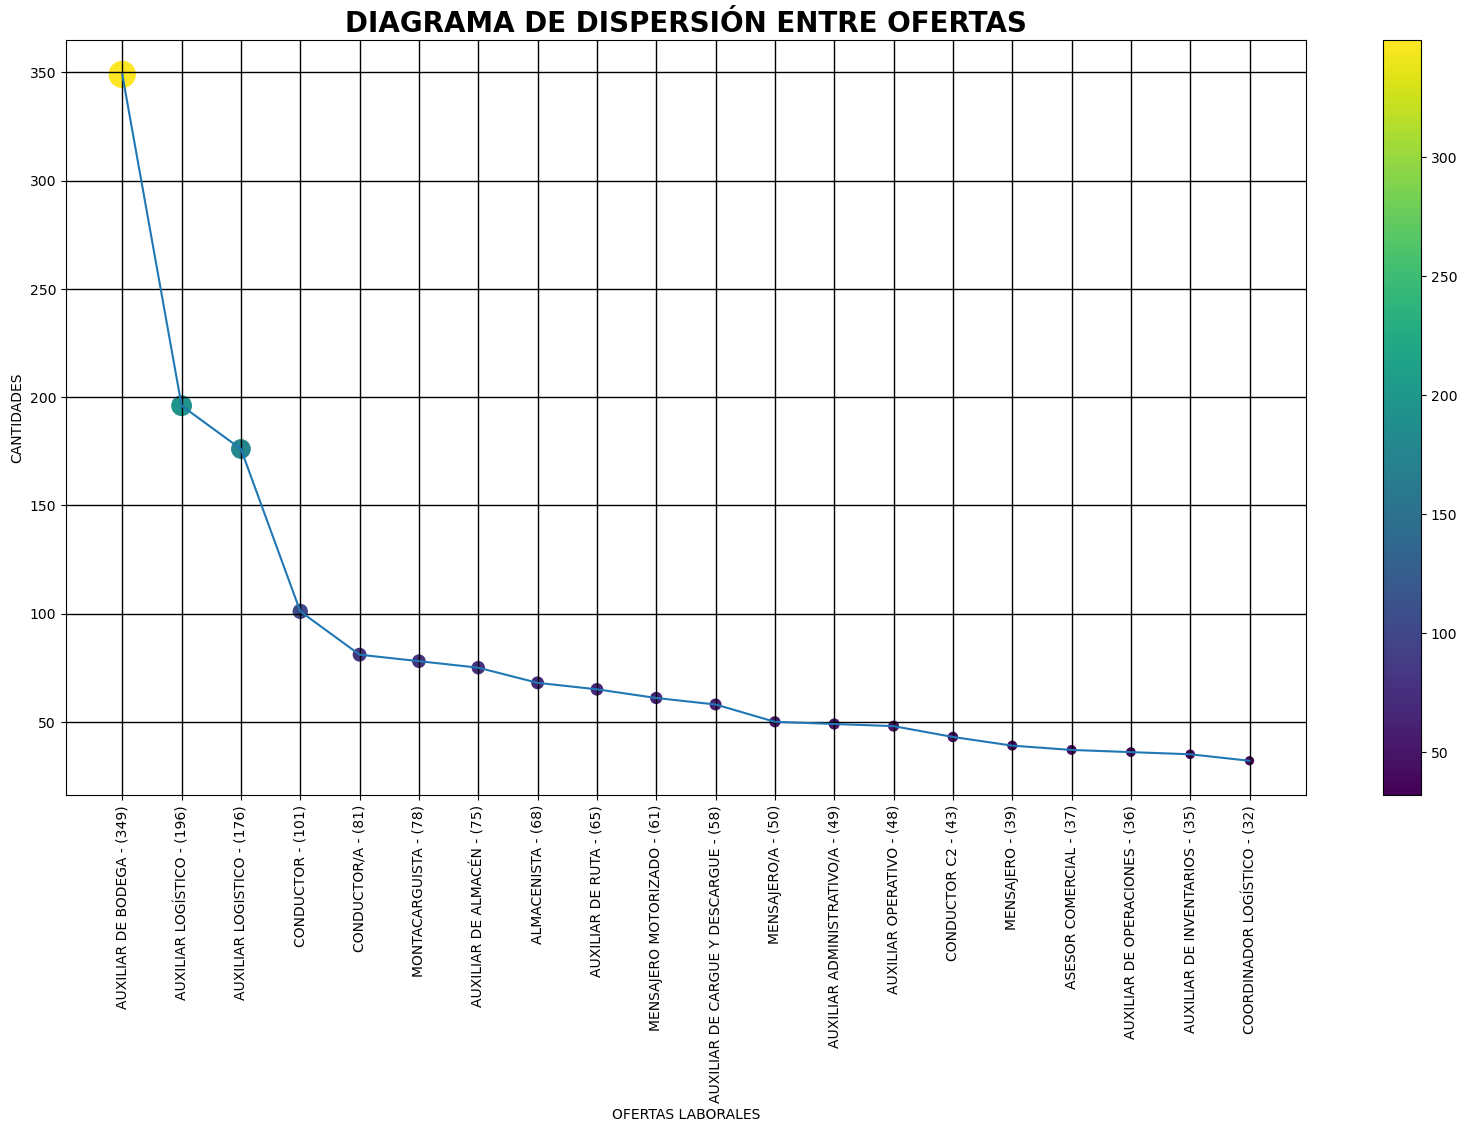

In [8]:
# Construcción del gráfico
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':100})
plt.scatter(x_values_top , y_values_top, marker = 'o', c = y_values_top, s = y_values_top)
plt.plot(x_values_top, y_values_top)
plt.colorbar()
plt.xticks(rotation = 90)
plt.ylabel('CANTIDADES')
plt.xlabel('OFERTAS LABORALES')
plt.title('DIAGRAMA DE DISPERSIÓN ENTRE OFERTAS', fontsize = 20, fontweight = "bold")
plt.grid(axis = 'both', color = 'k', linewidth = 1)
plt.show()
plt.close('all')

In [9]:
print("Ayudanos a encontrar posiblemente las mejores ofertas para ti...\n")

# Captura de intereses de la persona
job_of_interest = input('¿Cuál te interesa?: ')
job_of_location = input('¿Dónde te interesa?: ')
urgent = input('¿Quieres ver los que se precisan urgentes (si/no)?: ')
featured = input('¿Quieres ver las ofertas destacadas (si/no)?: ')

Ayudanos a encontrar posiblemente las mejores ofertas para ti...

¿Cuál te interesa?: auxiliar de bodega
¿Dónde te interesa?: valle
¿Quieres ver los que se precisan urgentes (si/no)?: si
¿Quieres ver las ofertas destacadas (si/no)?: si


In [10]:
# Validación de preferencias
if urgent == 'si': tags_urgents = 'se precisa urgente'
else: tags_urgents = '...'
    
if featured == 'si': tags_featured = 'empleo destacado'
else: tags_featured = '...'
    
# Creación del DataFrame con los intereses    
df_filter = df[
    (df['jobs_title'] == job_of_interest) &
    (df['companies_locations_after'].str.contains(job_of_location)) &
    (df['companies_calcifications'] != '...') &
    (df['tags_urgents'] == tags_urgents) &
    (df['tags_featured'] == tags_featured)
]

# Resultado final
best_offers = df_filter.sort_values('companies_calcifications', ascending = False)

# Cantidad de las mejores ofertas según interés
rows = len(df_filter.axes[0])

In [11]:
# Respuesta final para el usuario que está consultando
if rows == 0: msg = 'No se logró encontrar ofertas según tu interés'
elif rows == 1: msg = 'Te presentamos la mejor oferta según tus intereses'
elif rows > 1: msg = 'Te presentamos las mejores ' + str(rows) + ' ofertas según tus intereses...'

# Visulalización de resultados
print('\n' + msg)
best_offers


Te presentamos las mejores 2 ofertas según tus intereses...


,Unnamed: 0,tags_urgents,tags_featured,jobs_title,companies_name,companies_link,companies_calcifications,companies_locations_after,short_descriptions,how_longs
14,14,se precisa urgente,empleo destacado,auxiliar de bodega,staffing de colombia,https://co.computrabajo.com/empresas/ofertas-d...,"4,3","valle del cauca, cali",importante empresa requiere para su equipo de ...,hace 52 minutos
5944,6140,se precisa urgente,empleo destacado,auxiliar de bodega,transportadora la prensa del valle s.a.s.,https://co.computrabajo.com/empresas/ofertas-d...,"4,2","valle del cauca, yumbo",importante empresa del sector logístico y de t...,hace 4 días
